<a href="https://colab.research.google.com/github/JPrier/TorontoBikeShare/blob/master/BikeShare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Github

In [37]:
!git init

Reinitialized existing Git repository in /content/.git/
/bin/bash: JPrier: No such file or directory


In [0]:
!git remote rm origin
!git remote add origin https://github@github.com/JPrier/TorontoBikeShare.git

In [41]:
! git pull origin master

From https://github.com/JPrier/TorontoBikeShare
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Already up to date.


In [42]:
!git config --global user.email "JoshKPrier@Gmail.com"
!git config --global user.name "JPrier"

On branch master
Untracked files:
	.config/

nothing added to commit but untracked files present
fatal: could not read Password for 'https://github@github.com': No such device or address


In [7]:
!git add ./BikeShare.ipynb
!git status

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [8]:
!git commit -m "Added Beginning to Analysis"
!git push -u origin master

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


# Google Drive Setup

In [0]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!ls /content/drive/'My Drive'/Datasets/2017_BikeShare_Data/'2017 Data'/

ls: cannot access '/drive/My Drive/Datasets/2017_BikeShare_Data/2017 Data/': No such file or directory
/content


In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth 
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.2MB/s 


In [0]:
links = ["https://drive.google.com/open?id=1PJr79u_NpdDMWw0hVYuSwnWNPzsEs4fL",
         "https://drive.google.com/open?id=1O7-SLiTDhmKQN0yJQ-JOghjO_xM41hh1",
         "https://drive.google.com/open?id=1vUKpkTQ_kIlUNi0zJSJ92PPDXxBj6pB3",
         "https://drive.google.com/open?id=1eC8v2-auARPjVgKnv6JaiK7I-tmfwMI4"]

QX = ["Bikeshare Ridership (2017 Q1).csv", 
      "Bikeshare Ridership (2017 Q2).csv", 
      "Bikeshare Ridership (2017 Q3).csv",
      "Bikeshare Ridership (2017 Q4).csv"]

for i in range(len(links)):
  link = links[i]
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile(QX[i])

# Setup

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

QX = ["Bikeshare Ridership (2017 Q1).csv", 
      "Bikeshare Ridership (2017 Q2).csv", 
      "Bikeshare Ridership (2017 Q3).csv",
      "Bikeshare Ridership (2017 Q4).csv"]

# Variable Identification

### Predictor Variables:
 - trip_start_time
 - from_station_name
 - user_type

### Target Variable:
  - bikes_used -- Number of Bikes Used at a station (Bikes left - bikes arrived)

<br />

### Data_Types:
| Numerical             	| Character         	| DateTime        	|
|-----------------------	|-------------------	|-----------------	|
| trip_id               	| from_station_name 	| trip_start_time 	|
| trip_duration_seconds 	| to_station_name   	| trip_stop_time  	|
| bikes_used            	| user_type         	|                 	|

<br /><br />

### Variable Category

|    Categorical    | Continuous            |
|:-----------------:|-----------------------|
| trip_id           | trip_start_time       |
| from_station_name | trip_stop_time        |
| to_station_name   | trip_duration_seconds |
| user_type         | bikes_used            |



# Helper Functions

In [0]:
'''
Issues with this Dataset:
  - Q1 and Q2 are different from Q3 and Q4 in these ways:
      - station ids are non existent in only Q3 and Q4
      - date format switches from d-m-y to m-d-y for Q3 to a different one for Q4
      - Q4 uses a datetime var? excel shows a different format than what is actually there
'''

def read_data(quarters):
  df = pd.read_csv(QX[quarters[0]]).dropna()
  if quarters[0] == 0 or quarters[0] == 1:
    df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], 
                                                    format='%d/%m/%Y %H:%M')
    df['trip_stop_time'] = pd.to_datetime(df['trip_stop_time'], 
                                                   format='%d/%m/%Y %H:%M')
  elif quarters[0] == 3:
    df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], 
                                                    format='%m/%d/%y %H:%M:%S')
    df['trip_stop_time'] = pd.to_datetime(df['trip_stop_time'], 
                                                   format='%m/%d/%y %H:%M:%S')
  else:
    df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], 
                                                    format='%m/%d/%Y %H:%M')
    df['trip_stop_time'] = pd.to_datetime(df['trip_stop_time'], 
                                                   format='%m/%d/%Y %H:%M')
  #data = df.to_numpy()
  for i in range(len(quarters)-1):
    temp_df = pd.read_csv(QX[quarters[i+1]]).dropna()
    if quarters[i+1] == 0 or quarters[i+1] == 1:
      temp_df['trip_start_time'] = pd.to_datetime(temp_df['trip_start_time'], 
                                                  format='%d/%m/%Y %H:%M')
      temp_df['trip_stop_time'] = pd.to_datetime(temp_df['trip_stop_time'], 
                                                 format='%d/%m/%Y %H:%M')
    elif quarters[i+1] == 3:
      temp_df['trip_start_time'] = pd.to_datetime(temp_df['trip_start_time'], 
                                                      format='%m/%d/%y %H:%M:%S')
      temp_df['trip_stop_time'] = pd.to_datetime(temp_df['trip_stop_time'], 
                                                     format='%m/%d/%y %H:%M:%S')
    else:
      temp_df['trip_start_time'] = pd.to_datetime(temp_df['trip_start_time'], 
                                                  format='%m/%d/%Y %H:%M')
      temp_df['trip_stop_time'] = pd.to_datetime(temp_df['trip_stop_time'], 
                                                 format='%m/%d/%Y %H:%M')
    df = df.append(temp_df, sort=False)
      
    #data = np.append(data, df.to_numpy())
  if 'from_station_id' in df.columns:
      df.drop(['from_station_id', 'to_station_id'], axis=1, inplace=True)
  
  
  return df

# Run EDA

In [0]:
'''
-----TODO-----
- Read in and manipulate/clean data
- visualize data 
- perform more EDA
- predict rider usage on a day of the year?? (would need to add in another dataset -- possibly weather, holidays and events)
'''
# quarters to read in (just for speed of debugging)
quarters = [0, 1, 2, 3]
df = read_data(quarters)

In [6]:
print(df.shape)
print(df.iloc[1])
print(df.iloc[100000])

(1492368, 7)
trip_id                                    712383
trip_start_time               2017-01-01 00:00:00
trip_stop_time                2017-01-01 00:05:00
trip_duration_seconds                         279
from_station_name        Kendal Ave / Bernard Ave
to_station_name           Bathurst Subway Station
user_type                                  Member
Name: 1, dtype: object
trip_id                                        831014
trip_start_time                   2017-03-11 14:04:00
trip_stop_time                    2017-03-11 14:10:00
trip_duration_seconds                             385
from_station_name        Bathurst St / Fort York Blvd
to_station_name              Queen St W / Portland St
user_type                                      Member
Name: 100000, dtype: object


# Visualization

In [0]:
def visualization(df):
  #HeatMap of station usage
  
  #Avg users per day (with split on members vs casual)
  
  
  daily_freq = df.resample('D', on='trip_start_time').size()
  plt.figure()
  daily_freq.plot(x="Start Date", y="Amount of Riders")
  plt.show()

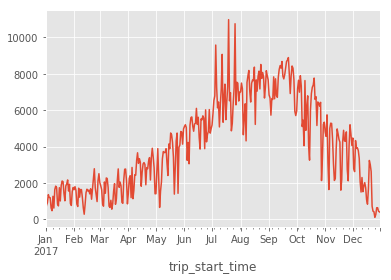

In [0]:
visualization(df)

<function matplotlib.pyplot.show>

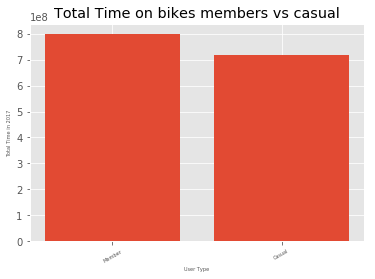

In [0]:
# Total time for casual vs member users

total_member_time = sum(df[df['user_type']=='Member']['trip_duration_seconds'])
total_casual_time = sum(df[df['user_type']=='Casual']['trip_duration_seconds'])

label = ["Member", "Casual"]
index = np.arange(len(label))
plt.bar(index, [total_member_time, total_casual_time])
plt.xlabel('User Type', fontsize=5)
plt.ylabel('Total Time in 2017', fontsize=5)
plt.xticks(index, label, fontsize=5, rotation=30)
plt.title('Total Time on bikes members vs casual')
plt.show

# Total number of users for each station (x2: one start, one stop)

# Total number of users for each unique trip

# 

<function matplotlib.pyplot.show>

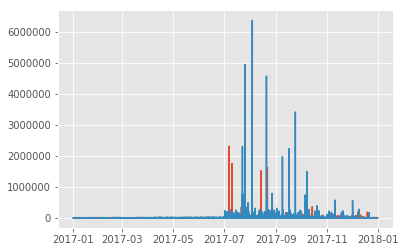

In [0]:
# Avg time per day for member vs casual

member_time = df[df['user_type']=='Member'][['trip_duration_seconds', 'trip_start_time']]
casual_time = df[df['user_type']=='Casual'][['trip_duration_seconds', 'trip_start_time']]

plt.plot(member_time['trip_start_time'], member_time['trip_duration_seconds'])
plt.plot(casual_time['trip_start_time'], casual_time['trip_duration_seconds'])
plt.show

<function matplotlib.pyplot.show>

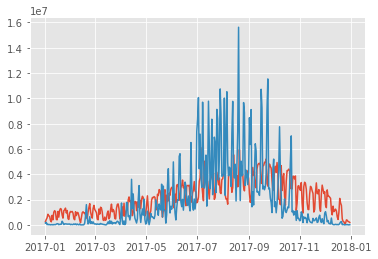

In [0]:
member_day_df = member_time.resample('D', on="trip_start_time").sum()
casual_day_df = casual_time.resample('D', on="trip_start_time").sum()
plt.plot(member_day_df)
plt.plot(casual_day_df)
plt.show

From these I can obviously conclude that the most frequent users in the mid year are casual users. But I can also see from this that member users are more consistent throughout the year as in the colder months it becomes much less frequent for a casual user to take a trip.

<function matplotlib.pyplot.show>

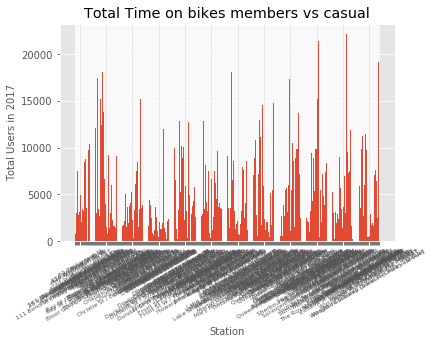

In [0]:
# Number of users over year at each station

stations_df = df.groupby("from_station_name").size()
label = stations_df.keys() #stations_df['from_station_name']
index = np.arange(len(label))
plt.bar(index, stations_df)
plt.xlabel('Station', fontsize=10)
plt.ylabel('Total Users in 2017', fontsize=10)
plt.xticks(index, label, fontsize=6, rotation=30)
plt.title('Total Time on bikes members vs casual')
plt.show


